# Classifiez automatiquement des biens de consommation

L'entreprise "Place de marché” souhaite lancer une marketplace e-commerce. Sur la "Place de marché", des vendeurs proposent des articles à des acheteurs en postant une photo et une description. Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable.<br>
<br>
L'objectif est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.<br>
<br>
Dans ce notebook, on va :
- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images,
- une réduction de dimension en deux dimensions,
- un clustering.

Avec pour contrainte :
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf,
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText),
- une approche de type word/sentence embedding avec BERT,
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

Pour extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

## Sommaire :
* [Importation des librairies](#chapter1)
* [Importation du dataset](#chapter2)
    * [Importation de base du dataset](#section_2_1)
* [Nettoyage du texte](#chapter3)
* [Traitement](#chapter4)
* [Fonctions communes](#chapter5)
* [Bag of word - Tf-idf](#chapter6)
    * [Préparation sentences](#section_6_1)
    * [Exécution des modèles](#section_6_2)
    * [Graphiques](#section_6_3)
* [Word2Vec](#chapter7)
    * [Création du modèle Word2Vec](#section_7_1)
    * [Création de la matrice d'embedding](#section_7_2)
    * [Création du modèle d'embedding](#section_7_3)
    * [Exécution du modèle](#section_7_4)
* [BERT](#chapter8)
    * [Fonctions communes](#section_8_1)
    * [BERT HuggingFace](#section_8_2)
* [USE - Universal Sentence Encoder](#chapter9)
* [Imagerie](#chapter10)
* [Création des labels des photos à partir du nom des images](#chapter11)
* [Affichage d'exemples d'images par label](#chapter12)
* [Détermination et affichage des descripteurs SIFT](#chapter13)
* [Pré-traitement des images via SIFT](#chapter14)
    * [Créations des descripteurs de chaque image](#section_14_1)
* [Création des clusters de descripteurs](#chapter15)
* [Création des features des images](#chapter16)
* [Réductions de dimension](#chapter17)
    * [Réduction de dimension PCA](#section_17_1)
    * [Réduction de dimension t-SNE](#section_17_2)
* [Analyse visuelle : affichage t-SNE selon catégories d'images](#chapter18)
* [Analyse mesures : similarité entre catégories et clusters](#chapter19)
    * [Création de clusters à partir du t-SNE](#section_19_1)
    * [Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters](#section_19_2)
    * [Analyse par classes](#section_19_3)
* ["CNN"](#chapter20)
    * ["Méthode : 1"](#section_20_1)
    * ["Méthode : 2"](#section_20_2)
* ["Méthode combinée"](#chapter21)

## Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mes fonctions
from P6_03_function import *

## Importation du dataset <a class="anchor" id="chapter2"></a>

In [2]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
print(data.shape)

(1050, 15)


### Information de base du dataset <a class="anchor" id="section_2_1"></a>

In [3]:
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

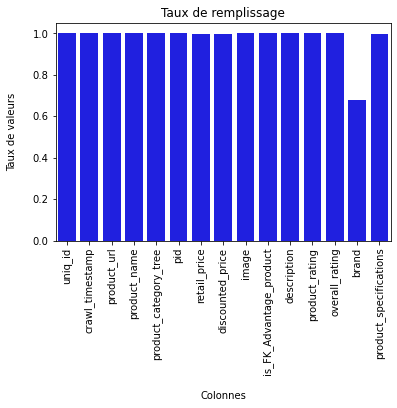

In [5]:
graphRemplissage(data)

## Nettoyage du texte <a class="anchor" id="chapter3"></a>

On va nettoyer deux colonnes, on va récupérer les catégories des produits, on utilise la colonne "product_category_tree" et récupérer les premières informations.

In [6]:
new = data["product_category_tree"].str.split(">>", n = 1, expand = True)
data["Categories"] = new[0]

Nettoyage du texte : "product_name"

In [7]:
data_T = data.copy()

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')', '"']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T['sentence_bow'] = data["product_name"].apply(lambda x : transform_bow_fct(x))
data_T['sentence_bow_lem'] = data["product_name"].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data["product_name"].apply(lambda x : transform_dl_fct(x))
data_T.shape

(1050, 19)

In [8]:
data_T["Categories"] = data_T["Categories"].apply(lambda x : transform_bow_lem_fct(x))

Dans cette partie, on a nettoyé nos données des valeurs :
- déterminant,
- verbes,
- chiffres,
- caractères spéciaux.

Comme nos descriptions sont en anglais, on utilise les stopwords en anglais.<br>
On prépare nos données et on construit un dictionnaire de mot pour :<br>
- bag of words pour (Countvectorizer et Tf_idf, Word2Vec),
- le bag of words avec lemmatization.<br>
La lemmatisation prend en compte le contexte et convertit le mot en sa forme de base significative.
- le Deep learning (USE et BERT).<br>
Cette technique permet de calculer la similarité sémantique entre les mots avec lesquels on peut construire un moteur de recherche sémantique.

Ce nettoyage, on le fait sur nos variables, "product_name" et "Categories".<br>
On créait 3 variables :
- 'sentence_bow_lem' : pour le t-SNE, cluster et ARI,
- 'sentence_bow' et 'sentence_dl' : pour calculer la longueur de nos mots.

## Traitement <a class="anchor" id="chapter4"></a>

In [9]:
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [10]:
l_cat = list(set(data_T["Categories"]))
y_cat_num = [(1-l_cat.index(data_T.iloc[i]["Categories"])) for i in range(len(data_T))]
print("Catégories : ", l_cat)

Catégories :  ['beauty personal care', 'watch', 'home furnishing', 'home decor festive need', 'baby care', 'computer', 'kitchen dining']


l_cat : affiche en liste les noms des catégories de produits.<br>
y_cat_num : affiche la liste des catégories par un nombre allant de 1 à -5.

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())

max length bow :  24
max length dl :  30


On calcule la taille des mots des variables de 'sentence_bow' et on le met dans la variable 'length_bow'. De même pour la variable 'sentence_dl', on la met dans 'length_dl'. Puis on affiche la taille maximum de "product_name".

## Fonctions communes <a class="anchor" id="chapter5"></a>

In [12]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

La première fonction permet de :
- Réduire de dimension notre jeu de donnée à 2 dimensions avec le t-SNE,
- Faire un clustering avec le KMEANS,
- Calcul de l'ARI entre vrais catégorie et n° de clusters.

La seconde fonction permet de visualiser le t-SNE entre les vrais catégories et les clusters. Voir si les vrais catégories sont bien représentés.

## Bag of word - Tf-idf <a class="anchor" id="chapter6"></a>
Ici, on construit un dictionnaire de mots.

### Préparation sentences <a class="anchor" id="section_6_1"></a>

In [13]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])

Création d'un dictionnaire de 2 manière différentes : (CountVectorizer et Tf-idf) avec les stop_words en anglais sur la variable 'sentence_bow_lem'.

### Exécution des modèles <a class="anchor" id="section_6_2"></a>

Calcul de l'ARI, en utilisant les valeurs qui a été créait par le dictionnaire des deux manière différentes.

In [14]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.3608 time :  12.0

Tf-idf : 
--------
ARI :  0.5041 time :  12.0


On remarque que la deuxième tecnhique (Tf-idf) est la meilleure.

### Graphiques <a class="anchor" id="section_6_3"></a>

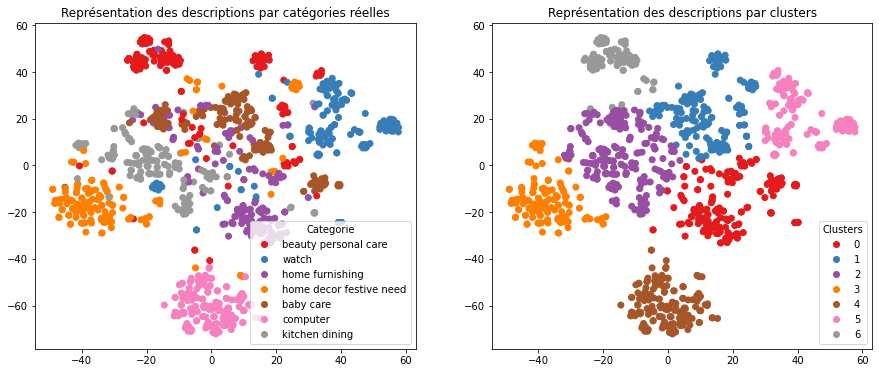

ARI :  0.5041


In [15]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Avec ces deux graphiques, on peut constater que :
- la catégorie "kitchen dining" est bien regroupé et bien représenté pour les clusters ;
- la catégorie "baby care", on peut voire qu'il est assez bien regroupé, mais aussi des points qui ne l'appartiennent pas se superposent ;
- la catégorie "computer" a un bon regroupement, mais des points aussi étalé, il est assez bien représenté ;
- la catégorie "watch" et "beauty personal care" est un peu dispersé, mais est assez bien représenté.
- les autres catégories sont mal représentés.

In [16]:
tab = pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters'])
tab

Clusters,0,1,2,3,4,5,6
Categories,,,,,,,
baby care,100,17,29,0,1,1,2
beauty personal care,8,2,127,11,0,1,1
computer,17,7,12,0,0,114,0
home decor festive need,6,12,8,114,4,0,6
home furnishing,26,95,27,1,0,0,1
kitchen dining,14,36,12,4,3,7,74
watch,0,0,0,0,150,0,0


<AxesSubplot:xlabel='Clusters', ylabel='Categories'>

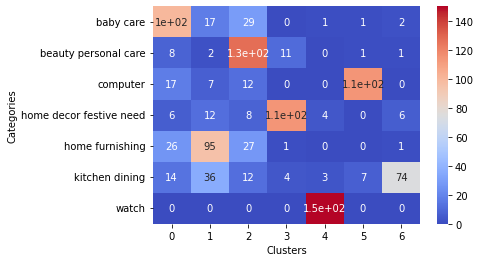

In [124]:
sns.heatmap(pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters']), annot=True, cmap = 'coolwarm')

Avec ces tableaux on peut voir que le :
- Cluster 0 va avec "home decor festive need" ;
- Cluster 1 va avec "home furnishing" ;
- Cluster 2 va avec "watch" ;
- Cluster 3 va avec "baby care" ;
- Cluster 4 va avec "beauty personal care" ;
- Cluster 5 va avec "kitchen dining" ;
- Cluster 6 va avec "computer".

In [125]:
tab.to_csv('bag_of_word')

## Word2Vec <a class="anchor" id="chapter7"></a>
Word2Vec repose sur des réseaux de neurones à deux couches et cherche à apprendre les représentations vectorielles des mots composant un texte, de telle sorte que les mots qui partagent des contextes similaires soient représentés par des vecteurs numériques proches.
- La dimensionnalité de l’espace vectoriel à construire ;
- La taille du contexte d’un mot.

### Création du modèle Word2Vec <a class="anchor" id="section_7_1"></a>
Importation de librairie

In [126]:
import tensorflow as tf
from tensorflow import keras 

import tensorflow.keras
from keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [127]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

Coupure des mots espacés d'une virgule, ces valeurs sont mis dans la variable "sentences".

In [128]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 1922
Word2Vec trained


In [129]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 1923


On créait et entraîne le modèle Word2Vec et la préparation des sentances. Le module "tokenize" fournit un scanner lexical.

### Création de la matrice d'embedding <a class="anchor" id="section_7_2"></a>

In [130]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (1923, 300)


Recherche des mots sémantiquement les plus proches.

### Création du modèle d'embedding <a class="anchor" id="section_7_3"></a>

In [131]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)


# Résumé du modèle
embed_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           576900    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 576,900
Trainable params: 576,900
Non-trainable params: 0
_________________________________________________________________


### Exécution du modèle <a class="anchor" id="section_7_4"></a>

In [132]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 970us/step


(1050, 300)

In [133]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.5071 time :  8.0


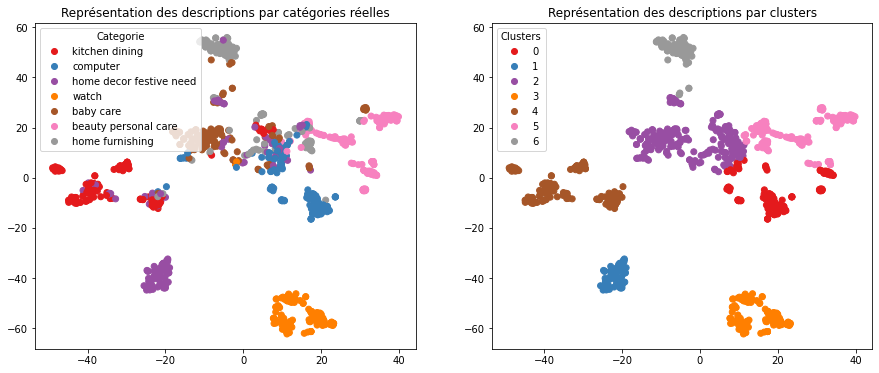

ARI :  0.5071


In [134]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Avec ces deux graphiques, on peut constater que :
- La catégorie "computer" est très bien représentés,
- La catégorie "kitchen" est assez bien présentés, même si on voit des points éparpillés
- La catégorie "home furnishing" est plutôt bien représenté, mais il y a des points des autres catégories qui s'y mêlent et a des points étalés.
- La catégorie "home decor festive need" est en partie représenté.
- Les autres catégories ne sont pas assez bien représentés.

In [135]:
pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters'])

Clusters,0,1,2,3,4,5,6
Categories,,,,,,,
baby care,3,81,34,0,28,3,1
beauty personal care,103,0,40,0,2,5,0
computer,33,0,4,0,0,113,0
home decor festive need,3,0,126,0,1,11,9
home furnishing,0,0,12,0,138,0,0
kitchen dining,2,0,35,0,2,38,73
watch,0,0,7,143,0,0,0


<AxesSubplot:xlabel='Clusters', ylabel='Categories'>

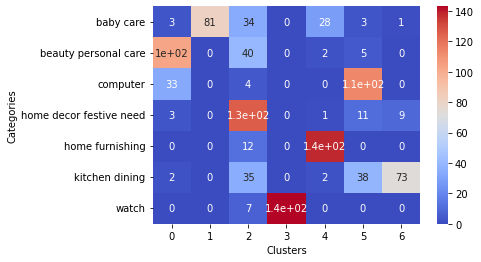

In [136]:
sns.heatmap(pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters']), cmap = 'coolwarm', annot=True)

Avec ces tableaux on peut voir que le :
- Cluster 0 va avec "beauty personal care" ;
- Cluster 1 va avec "kitchen dining" ;
- Cluster 2 va avec "watch" ;
- Cluster 3 va avec "home decor festive need" ;
- Cluster 4 va avec "home furnishing" ;
- Cluster 5 va avec "baby care" ;
- Cluster 6 va avec "computer".

## BERT <a class="anchor" id="chapter8"></a>

In [137]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
#from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [138]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


### Fonctions communes <a class="anchor" id="section_8_1"></a>

BERT est un modèle de représentation de textes écrit en langage naturel.

In [139]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT HuggingFace <a class="anchor" id="section_8_2"></a>

Modèle : 'bert-base-uncased'

In [140]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [141]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 1s/step
temps traitement :  129.0


In [142]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.6109 time :  8.0


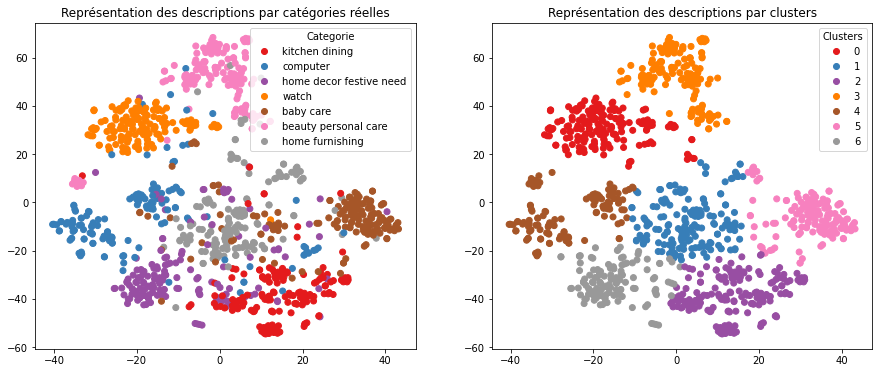

ARI :  0.6109


In [143]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Avec cette technique on peut voir que le graphique de gauche plusieurs groupe distinct, mais des points restent mélangés. <br>
La catégorie "computer" est plutôt bien représentée. <br>
Et enfin, la catégorie "home furnishing" est moyennement bien représenté.

In [144]:
pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters'])

Clusters,0,1,2,3,4,5,6
Categories,,,,,,,
baby care,1,21,20,0,6,4,98
beauty personal care,10,8,8,3,102,9,10
computer,2,0,0,137,11,0,0
home decor festive need,4,26,6,0,4,106,4
home furnishing,0,4,137,0,1,4,4
kitchen dining,7,113,1,7,0,17,5
watch,149,1,0,0,0,0,0


<AxesSubplot:xlabel='Clusters', ylabel='Categories'>

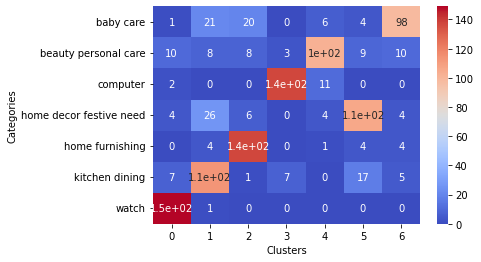

In [145]:
sns.heatmap(pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters']), cmap = 'coolwarm', annot=True)

Avec ces tableaux on peut voir que le :
- Cluster 0 va avec "baby care" ;
- Cluster 1 va avec "beauty personal care" ;
- Cluster 2 va avec "watch" ;
- Cluster 3 va avec "computer" ;
- Cluster 4 va avec "home furnishing" ;
- Cluster 5 va avec "kitchen dining" ;
- Cluster 6 va avec "home decor festive need".

## USE - Universal Sentence Encoder <a class="anchor" id="chapter9"></a>

In [146]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [147]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [148]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [149]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [150]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [151]:
features_USE = feature_USE_fct(sentences, batch_size)

In [152]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.6436 time :  8.0


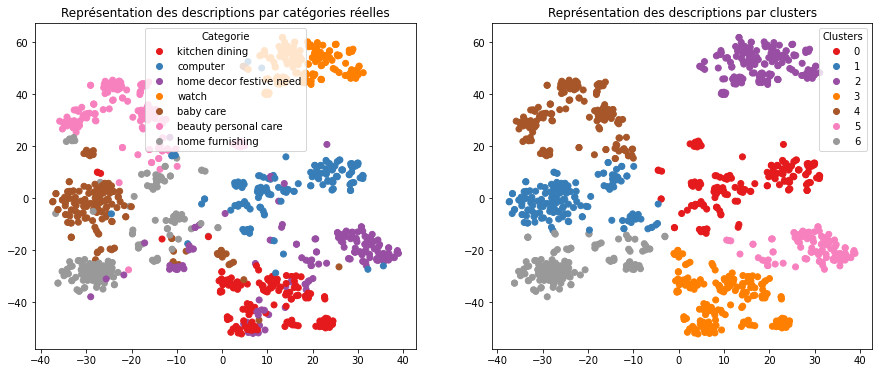

ARI :  0.6436


In [153]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

Dans le graphique de gauche, on peut voir que les catégories sont moins bien regoupé. <br>
- La catégorie "computer" est plutôt présenté,
- Le cluster "home furnishing" est moins bien présenté et étalés.<br>
- Le cluster "watch" un peu étalé, est assez bien regroupé
Le reste des clusters ne sont pas bien resprésentés, les points sont mélangés.

In [154]:
tab = pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters'])
tab

Clusters,0,1,2,3,4,5,6
Categories,,,,,,,
baby care,8,3,0,28,1,92,18
beauty personal care,136,2,2,1,3,5,1
computer,11,5,0,0,133,0,1
home decor festive need,0,103,3,12,10,1,21
home furnishing,0,3,0,145,0,0,2
kitchen dining,5,46,0,0,8,0,91
watch,0,0,150,0,0,0,0


<AxesSubplot:xlabel='Clusters', ylabel='Categories'>

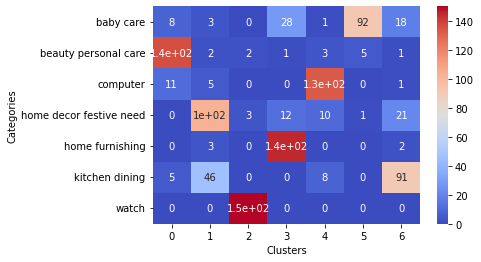

In [155]:
sns.heatmap(pd.crosstab(data_T["Categories"], labels, colnames = ['Clusters']), cmap = 'coolwarm', annot=True)

Avec ces tableaux on peut voir que le :
- Cluster 0 va avec "beauty personal care" ;
- Cluster 1 va avec "baby care" ;
- Cluster 2 va avec "watch" ;
- Cluster 3 va avec "kitchen dining" ;
- Cluster 4 va avec "home furnishing" ;
- Cluster 5 va avec "home decor festive need" ;
- Cluster 6 va avec "computer".

In [156]:
tab.to_csv('use')
data_T.to_csv('flipkart_image', index=False)

## Imagerie <a class="anchor" id="chapter10"></a>

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from sklearn import preprocessing

# Mes fonctions
from P6_03_function import *

## Création des labels des photos à partir du nom des images <a class="anchor" id="chapter11"></a>

On créait un nouveau dataframe avec la liste des Catégories selon les images et on ajoute un label qui va de 0 à 6

In [2]:
data_T = pd.read_csv("flipkart_image")
list_labels = list(set(data_T["Categories"]))

df = pd.DataFrame()

df["image_path"] = data_T["image"]
df["label_name"] = data_T["Categories"]
df["product_name"] = data_T["sentence_dl"]
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["label_name"])
df.head(3)

,image_path,label_name,product_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,elegance polyester multicolor abstract eyelet ...,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,sathiyas cotton bath towel,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,eurospa cotton terry face towel set,0


In [3]:
df.groupby("label").count()

,image_path,label_name,product_name
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


Nos images, selon les catégories, sont égaux.

## Affichage d'exemples d'images par label <a class="anchor" id="chapter12"></a>

Ici on va afficher les images selons les catégories, on affiche le lien du dossier image.

-------
kitchen dining


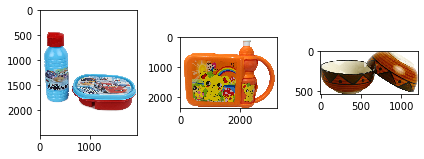

-------
computer


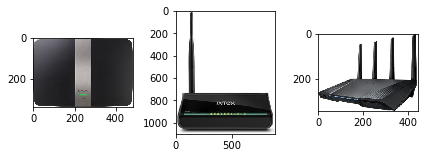

-------
home decor festive need


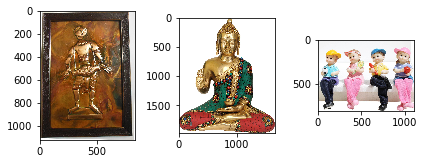

-------
watch


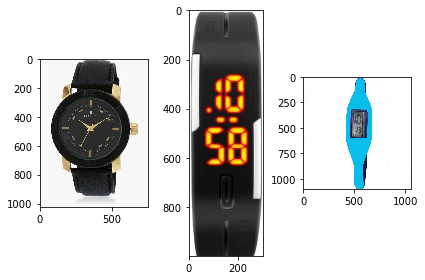

-------
baby care


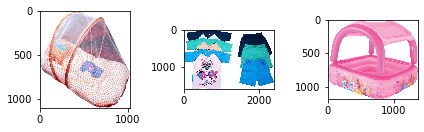

-------
beauty personal care


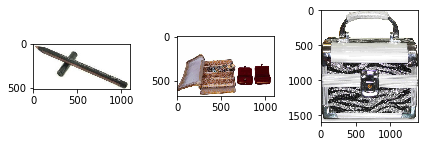

-------
home furnishing


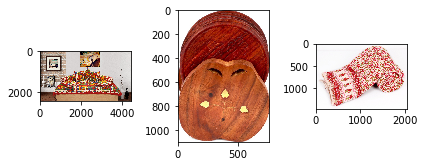

-------


In [4]:
from matplotlib.image import imread
import skimage.io as io

path = r"C:/Users/cisso/Projet 6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/"

list_photos = data_T["image"]

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(df)) if df["label_name"][i] == name]
    return list_image_name

for name in list_labels :
    print("-------")
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        io.imshow(image)
    io.show()
print("-------")

## Détermination et affichage des descripteurs SIFT <a class="anchor" id="chapter13"></a>

Le SIFT/ORB/SURF permetent d'extraire des descripteurs, par la suie, nous utiliserons par la suit l'algorithme SIFT.<br>
Ici on va afficher le nombre de descripteurs. On ouvre notre image et on la convertit en gris. On utilise l'alogorithme de SIFT pour détecter les points importants de l'image.

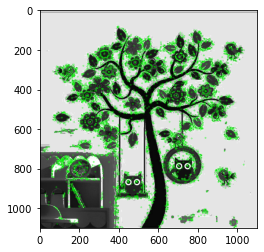

In [5]:
import cv2

img = io.imread(path + list_photos[1049], cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.equalizeHist(img)   #equalize image histogram
sift = cv2.SIFT_create()
keypoints_sift, descriptors = sift.detectAndCompute(img, None)
img_1 = cv2.drawKeypoints(img, keypoints_sift, None, color=(0,255,0), flags=0)
plt.imshow(img_1)

In [6]:
print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

Descripteurs :  (6560, 128)

[[101.   5.   0. ...   5.   0.   0.]
 [ 32.   5.   0. ...   1.  93.  95.]
 [  0.   0.   0. ...   4.   1.   0.]
 ...
 [ 22.  16.   1. ...   0.   0.   0.]
 [  0.   5.  37. ...   0.   0.   1.]
 [  0.   3.  18. ...  64.  25.   4.]]


L'image contient 6560 descripteurs. Certaines images pouvant monter jusqu'à 35 mille descripteurs<br>
Chaque descripteur est un vecteur de longueur 128.<br>

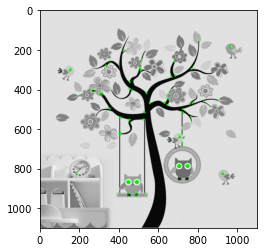

In [7]:
img = io.imread(path + list_photos[1049], cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create()
keypoints_orb, descriptors = orb.detectAndCompute(img, None)
img_2 = cv2.drawKeypoints(img, keypoints_orb, None, color=(0,255,0), flags=0)
plt.imshow(img_2)

In [8]:
print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)

Descripteurs :  (500, 32)

[[139 197 103 ... 159 249  86]
 [ 24 173  19 ...  10  48 168]
 [146  41  99 ...  10 115 168]
 ...
 [ 13 129 249 ... 195 193 160]
 [ 67 148  55 ... 132 161 125]
 [ 78 203 172 ...  14  29  86]]


## Pré-traitement des images via SIFT <a class="anchor" id="chapter14"></a>

### Créations des descripteurs de chaque image <a class="anchor" id="section_17_1"></a>

On va regarder les descripteurs de chaque image, on convertit l'image en gris. On créait une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image. Ensuite, on créait une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs.

In [9]:
from PIL import Image
import time

Image.MAX_IMAGE_PIXELS = None

# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(9000)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = io.imread(path + list_photos[image_num], cv2.IMREAD_GRAYSCALE) # convert in gray
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)   #equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype = object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis = 0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (4494772, 128)
temps de traitement SIFT descriptor :           582.53 secondes


## Création des clusters de descripteurs <a class="anchor" id="chapter15"></a>
On va créait des clusters selon les descripteurs avec la méthode de MiniBatchKmeans.<br>
MiniBatchKmeans sélectionne les centres de cluster initiaux, pour le clustering k-mean de manière intelligente afin d'accélérer la convergence.<br>
On met une valeur à "batch_size = 3000" pour éviter les fuites de données.

In [10]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0, batch_size = 3000)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  2120
Création de 2120 clusters de descripteurs ...
temps de traitement kmeans :           563.50 secondes


## Création des features des images <a class="anchor" id="chapter16"></a>

Pour chaque image, on va :
- prédire des numéros de cluster de chauqe descripteur
- création d'un histogramme (comptage pour chaque numéro de cluster du nombre de descripteurs de l'image)

- Features d'une image
- Histogramme d'une image
- Comptage pour une image du nombre de descripteurs par cluster

In [11]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            57.56 secondes


## Réductions de dimension <a class="anchor" id="chapter17"></a>

### Réduction de dimension ACP <a class="anchor" id="section_17_1"></a>
La réduction ACP permet de diminuer la dimension, créer des features décorrélées entre elles en gardant une variance élevée et de diminuer le temps de calcul.

In [12]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2120)
Dimensions dataset après réduction PCA :  (1050, 715)


### Réduction de dimension t-SNE <a class="anchor" id="section_17_2"></a>
Avec le t-SNE on réduit à 2 dimensions.<br>
Avec cette méthode, on convertit les similitudes entre les points de données en probabilités conjointes et tente de minimiser la divergence.

In [13]:
tsne = manifold.TSNE(n_components = 2, perplexity = 30,
                     n_iter = 2000, init = 'random', random_state = 7)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label_name"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage t-SNE selon catégories d'images <a class="anchor" id="chapter18"></a>

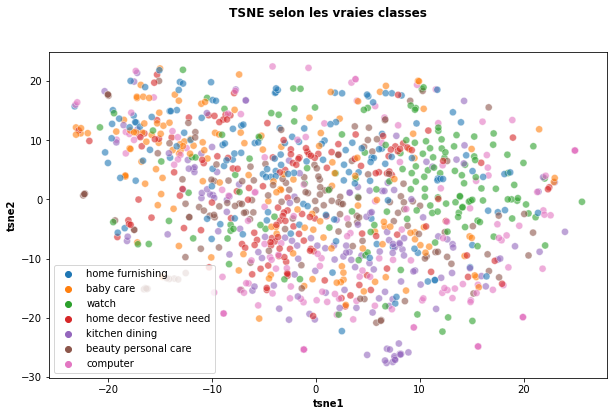

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

Les points son mélangés et on ne peut pas tirer d'information. On peut voir un regroupement du cluster "watch", mais la méthode du "SIFT" n'est pas une bonne méthode pour le projet.

## Analyse mesures : similarité entre catégories et clusters <a class="anchor" id="chapter19"></a>

### Création de clusters à partir du t-SNE <a class="anchor" id="section_19_1"></a>

In [15]:
cls = cluster.KMeans(n_clusters=7, random_state = 7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters <a class="anchor" id="section_19_2"></a>

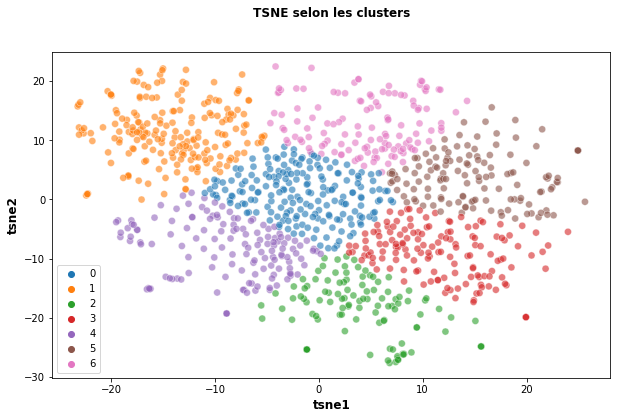

ARI :  0.05494740798126638


In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Notre score ARI est très faible.

### Analyse par classes <a class="anchor" id="section_19_3"></a>

On va effectuer une matrice de confusion.<br>

In [17]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    194
1    201
2    109
3    146
4    142
5    131
6    127
Name: class, dtype: int64

In [18]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[25 60 13 19 13  6 14]
 [52 15  7 21 32 10 13]
 [12 20 35 29 19 18 17]
 [34 27  8 11 38  9 23]
 [31 47  4 11  7 15 35]
 [27 20 35 36 19 11  2]
 [13 12  7 19 14 62 23]]


<AxesSubplot:>

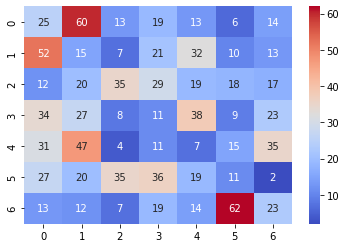

In [19]:
sns.heatmap(conf_mat, annot=True, cmap = 'coolwarm')

In [20]:
corresp = np.argmax(conf_mat, axis=0)
corresp

array([1, 0, 2, 5, 3, 6, 4], dtype=int64)

In [21]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1, 0, 2, 5, 3, 6, 4]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1, 0, 2, 5, 3, 6, 4]
[[60 25 13 13 14 19  6]
 [15 52  7 32 13 21 10]
 [20 12 35 19 17 29 18]
 [27 34  8 38 23 11  9]
 [47 31  4  7 35 11 15]
 [20 27 35 19  2 36 11]
 [12 13  7 14 23 19 62]]

              precision    recall  f1-score   support

           0       0.30      0.40      0.34       150
           1       0.27      0.35      0.30       150
           2       0.32      0.23      0.27       150
           3       0.27      0.25      0.26       150
           4       0.28      0.23      0.25       150
           5       0.25      0.24      0.24       150
           6       0.47      0.41      0.44       150

    accuracy                           0.30      1050
   macro avg       0.31      0.30      0.30      1050
weighted avg       0.31      0.30      0.30      1050



<AxesSubplot:>

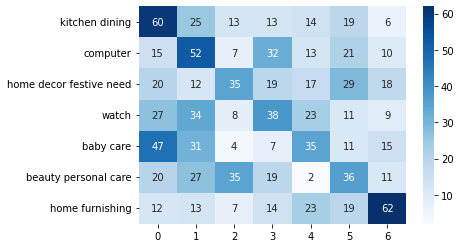

In [22]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## CNN <a class="anchor" id="chapter20"></a>

### Méthode : 1 <a class="anchor" id="section_20_1"></a>

L'algorithme CNN permet de classer les images par la formation d'un simple réseau de neurones convolutifs. Nous allons créer un modèle de base à partir du modèle VGG16.

In [23]:
import tensorflow as tf
from tqdm import tqdm
import pathlib
#from keras_preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import image
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import os
import random

Maintenant, nous devons prétraiter les données (former, tester, valider), ce qui inclut la remise à l'échelle et un mélange de nos valeurs pour pouvoir tirer les images aléatoirement.

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = r"C:\Users\cisso\Projet 6\Dataset+projet+prétraitement+textes+images\Flipkart"

IMG_SHAPE  = 160
batch_size = 32

image_gen_train = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                    directory = path,
                                                    shuffle = True,
                                                    target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    class_mode = 'binary')

image_generator_validation = ImageDataGenerator(rescale = 1./255)

val_data_gen = image_generator_validation.flow_from_directory(batch_size = batch_size,
                                                            directory = path,
                                                            shuffle = True,
                                                            target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary')

image_gen_test = ImageDataGenerator(rescale = 1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size = batch_size,
                                                    directory = path,
                                                    shuffle = True,
                                                    target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    class_mode ='binary')

Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.
Found 1050 images belonging to 5 classes.


On peut constater que notre prétraitement de nos données montre que nous avons 4 classes différentes, par la suite, on va laisser à 4, malgrès nos 7 clusters.<br>
On va utilisser le modèle VGG16 qui est un réseau de neuronnes de convolution. Avec "mayer.trainable" mit à "False" permet de géler les couches.
On créait une couche "Dense" à 512, puis on overfit nos données, en donnant 80% des images, puis ont rajoute 2 couches "Dense" et notre dernière couche, on la met 4.

In [40]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(160, 160, 3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(40, activation = 'relu')(x)
x = tf.keras.layers.Dense(4, activation = 'relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


 Compilons le modèle avant de commencer l'entraînement.

In [41]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate = 1e-4, momentum = 0.9)
model.compile(optimizer = opt,
            loss = tf.keras.losses.sparse_categorical_crossentropy,
            metrics=["acc"])

Résumé du modèle.

In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0   

Enfin, nous allons faire un "fit" de notre modèle. On ajoute un "EarlyStopping" pour qu'il s'arrête quand la valeur d'accuracy reste constante, mais il doit faire 16 minimum epochs.

In [43]:
# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_acc', 
                    patience = 5,
                    mode = "max",)

vgg_classifier = model.fit(train_data_gen,
                            epochs=100, 
                            steps_per_epoch=2,
                            validation_steps=2,
                            validation_data = val_data_gen,
                            callbacks = [es])

Epoch 1/100
2/2 [==============================] - 20s 14s/step - loss: 1.6281 - acc: 0.4219 - val_loss: 1.6148 - val_acc: 0.8750
Epoch 2/100
2/2 [==============================] - 18s 13s/step - loss: 1.6228 - acc: 0.8281 - val_loss: 1.6192 - val_acc: 0.8906
Epoch 3/100
2/2 [==============================] - 18s 13s/step - loss: 1.6162 - acc: 0.7969 - val_loss: 1.6177 - val_acc: 0.8750
Epoch 4/100
2/2 [==============================] - 18s 13s/step - loss: 1.6370 - acc: 0.7344 - val_loss: 1.6227 - val_acc: 0.8125
Epoch 5/100
2/2 [==============================] - 18s 13s/step - loss: 1.6226 - acc: 0.8125 - val_loss: 1.6130 - val_acc: 0.8438
Epoch 6/100
2/2 [==============================] - 18s 13s/step - loss: 1.6161 - acc: 0.7500 - val_loss: 1.6100 - val_acc: 0.8750
Epoch 7/100
2/2 [==============================] - 18s 13s/step - loss: 1.6271 - acc: 0.7500 - val_loss: 1.6089 - val_acc: 0.9531
Epoch 8/100
2/2 [==============================] - 18s 13s/step - loss: 1.6157 - acc: 0.81

Maintenant, nous allons tester nos modèles sur nos données à tester et à entraîner et on peut constater que nos données sont bonnes.

In [44]:
validation_steps = 20

loss0, accuracy0 = model.evaluate(val_data_gen, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 84s 4s/step - loss: 1.5869 - acc: 0.9688
loss: 1.59
accuracy: 0.97


In [45]:
validation_steps = 20

loss0, accuracy0 = model.evaluate(test_data_gen, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 84s 4s/step - loss: 1.5867 - acc: 0.9656
loss: 1.59
accuracy: 0.97


In [46]:
validation_steps = 20

loss0, accuracy0 = model.evaluate(train_data_gen, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 84s 4s/step - loss: 1.5869 - acc: 0.9672
loss: 1.59
accuracy: 0.97


On examine nos données sous formes graphique pour voir son évolution.

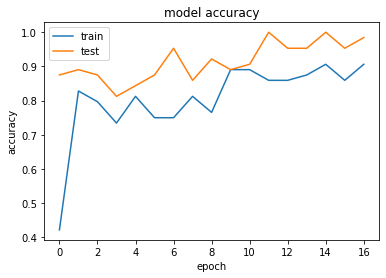

In [47]:
plt.plot(vgg_classifier.history['acc'])
plt.plot(vgg_classifier.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

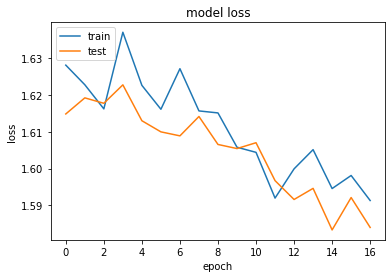

In [48]:
# summarize history for loss
plt.plot(vgg_classifier.history['loss'])
plt.plot(vgg_classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
from tensorflow.keras.preprocessing import image

path = r"C:/Users/cisso/Projet 6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/"

train_image = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img(path+df["image_path"][i], target_size=(160,160,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1050/1050 [00:28<00:00, 37.31it/s]


In [50]:
features = model.predict(X)
print(features.shape)

33/33 [==============================] - 133s 4s/step
(1050, 5)


In [51]:
tsne = manifold.TSNE(n_components = 2, perplexity = 30,
                     n_iter = 2000, init = 'random', random_state = 7)
X_tsne = tsne.fit_transform(features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label_name"]
print(df_tsne.shape)

(1050, 3)


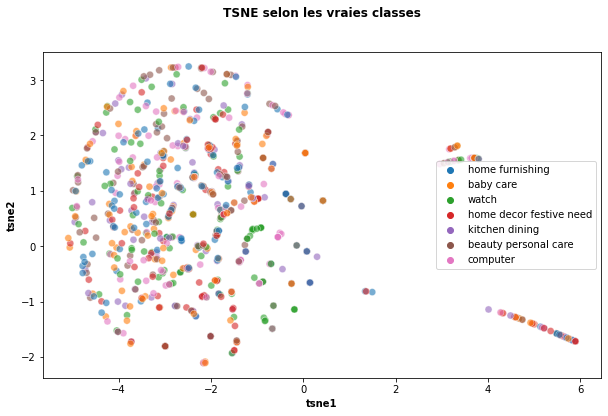

In [52]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

In [53]:
cls = cluster.KMeans(n_clusters=7, random_state = 7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


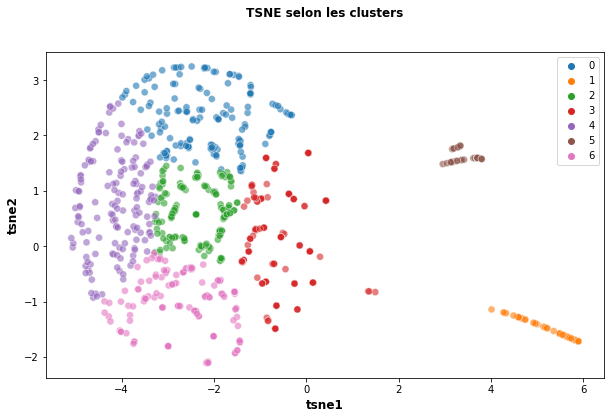

ARI :  0.014731952753860418


In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [55]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    158
1     56
2    332
3    157
4    150
5     39
6    158
Name: class, dtype: int64

In [56]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[19 10 42 20 27  7 25]
 [32  2 60 17 25  3 11]
 [29  4 38 37 16 11 15]
 [18 14 46 10 15  3 44]
 [23 13 52 29 27  0  6]
 [16 12 59 12 16  2 33]
 [21  1 35 32 24 13 24]]


<AxesSubplot:>

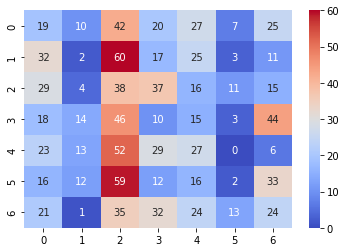

In [57]:
sns.heatmap(conf_mat, annot=True, cmap = 'coolwarm')

In [58]:
corresp = np.argmax(conf_mat, axis=0)
corresp

array([1, 3, 1, 2, 0, 6, 3], dtype=int64)

In [59]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [1, 3, 4, 2, 0, 6, 5]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1, 3, 4, 2, 0, 6, 5]
[[27 19 20 10 42 25  7]
 [25 32 17  2 60 11  3]
 [16 29 37  4 38 15 11]
 [15 18 10 14 46 44  3]
 [27 23 29 13 52  6  0]
 [16 16 12 12 59 33  2]
 [24 21 32  1 35 24 13]]

              precision    recall  f1-score   support

           0       0.18      0.18      0.18       150
           1       0.20      0.21      0.21       150
           2       0.24      0.25      0.24       150
           3       0.25      0.09      0.14       150
           4       0.16      0.35      0.22       150
           5       0.21      0.22      0.21       150
           6       0.33      0.09      0.14       150

    accuracy                           0.20      1050
   macro avg       0.22      0.20      0.19      1050
weighted avg       0.22      0.20      0.19      1050



<AxesSubplot:>

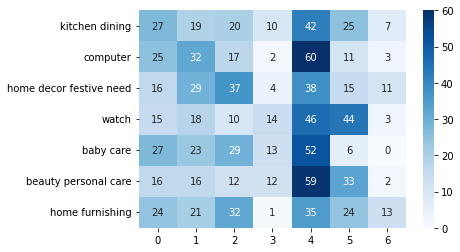

In [60]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### Méthode : 2 <a class="anchor" id="section_20_2"></a>

In [82]:
from tensorflow.keras.preprocessing import image

path = r"C:/Users/cisso/Projet 6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/"

train_image = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img(path+df["image_path"][i], target_size=(160,160,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1050/1050 [00:26<00:00, 39.96it/s]


In [83]:
X.shape

(1050, 160, 160, 3)

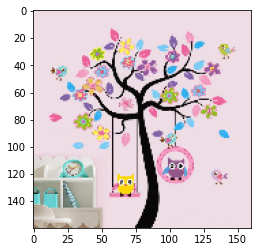

In [84]:
plt.imshow(X[1049])

In [85]:
df['label_name'][1049]

'baby care'

In [86]:
y = np.array(df.drop(['image_path', 'label_name', "product_name"],axis=1))
y.shape

(1050, 1)

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [88]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(160,160,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='sigmoid'))

In [89]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 156, 156, 16)      1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 78, 78, 16)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 78, 78, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 74, 74, 32)        12832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 37, 37, 32)       

In [90]:
model.compile(optimizer = "adam",
            loss = tf.keras.losses.sparse_categorical_crossentropy,
            metrics=["accuracy"])

In [91]:
hist = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/30
15/15 [==============================] - 20s 1s/step - loss: 1.9722 - accuracy: 0.1450 - val_loss: 1.9485 - val_accuracy: 0.0667
Epoch 2/30
15/15 [==============================] - 21s 1s/step - loss: 1.9456 - accuracy: 0.1312 - val_loss: 1.9477 - val_accuracy: 0.0667
Epoch 3/30
15/15 [==============================] - 21s 1s/step - loss: 1.9453 - accuracy: 0.1556 - val_loss: 1.9465 - val_accuracy: 0.0667
Epoch 4/30
15/15 [==============================] - 20s 1s/step - loss: 1.9319 - accuracy: 0.1418 - val_loss: 1.9418 - val_accuracy: 0.0857
Epoch 5/30
15/15 [==============================] - 20s 1s/step - loss: 1.9445 - accuracy: 0.1450 - val_loss: 1.9447 - val_accuracy: 0.2286
Epoch 6/30
15/15 [==============================] - 18s 1s/step - loss: 1.9382 - accuracy: 0.1471 - val_loss: 1.9342 - val_accuracy: 0.2476
Epoch 7/30
15/15 [==============================] - 19s 1s/step - loss: 1.9351 - accuracy: 0.1968 - val_loss: 1.9313 - val_accuracy: 0.2571
Epoch 8/30
15/15 [==

1/1 [==============================] - 0s 109ms/step
kitchen dining (0.713)
baby care (0.655)
watch (0.648)
computer (0.438)
home furnishing (0.363)
beauty personal care (0.259)
home decor festive need (0.232)


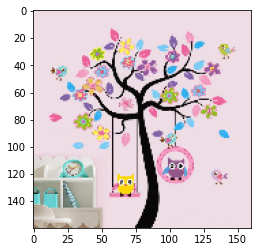

In [92]:
img = X[1049]

classes = np.array(df.columns[3])
proba = model.predict(img.reshape(1,160,160,3))
top_3 = np.argsort(proba[0])[:-8:-1]
for i in range(7):
    print("{}".format(list_labels[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

In [93]:
features = model.predict(X)
print(features.shape)

33/33 [==============================] - 5s 145ms/step
(1050, 7)


In [94]:
tsne = manifold.TSNE(n_components = 2, perplexity = 30,
                     n_iter = 2000, init = 'random', random_state = 7)
X_tsne = tsne.fit_transform(features)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label_name"]
print(df_tsne.shape)

(1050, 3)


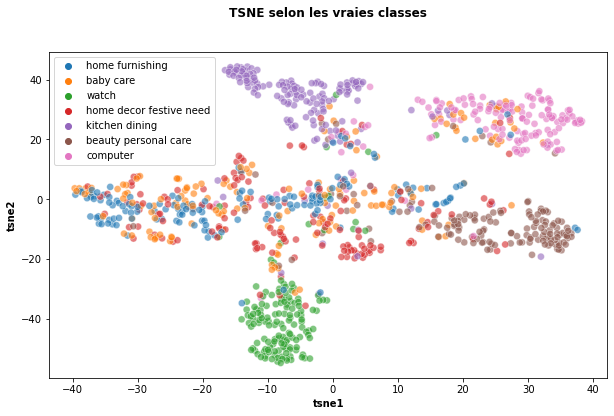

In [95]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

In [96]:
cls = cluster.KMeans(n_clusters=7, random_state = 7)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


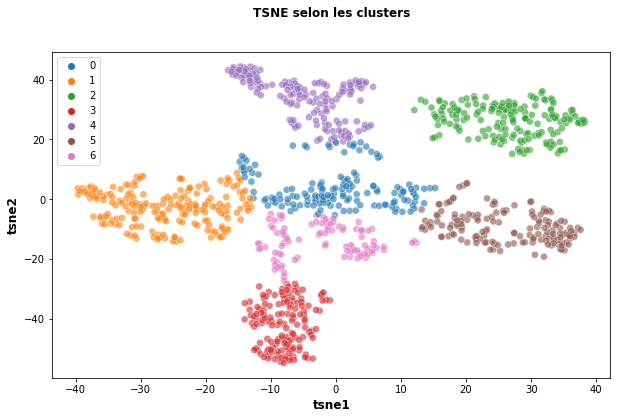

ARI :  0.4468105954838804


In [97]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 12, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [98]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    147
1    195
2    173
3    143
4    148
5    151
6     93
Name: class, dtype: int64

In [99]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 33  64  23   2   5   7  16]
 [ 19   4   4   0   3 115   5]
 [ 10   1 130   1   7   1   0]
 [ 28  46   3   3   3  13  54]
 [ 47  76   4   3   2  13   5]
 [  6   2   8   1 127   2   4]
 [  4   2   1 133   1   0   9]]


<AxesSubplot:>

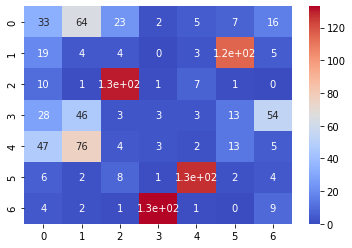

In [100]:
sns.heatmap(conf_mat, annot=True, cmap = 'coolwarm')

In [101]:
corresp = np.argmax(conf_mat, axis=0)
corresp

array([4, 4, 2, 6, 5, 1, 3], dtype=int64)

In [102]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 0, 2, 6, 5, 1, 3]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4, 0, 2, 6, 5, 1, 3]
[[ 64   7  23  16  33   5   2]
 [  4 115   4   5  19   3   0]
 [  1   1 130   0  10   7   1]
 [ 46  13   3  54  28   3   3]
 [ 76  13   4   5  47   2   3]
 [  2   2   8   4   6 127   1]
 [  2   0   1   9   4   1 133]]

              precision    recall  f1-score   support

           0       0.33      0.43      0.37       150
           1       0.76      0.77      0.76       150
           2       0.75      0.87      0.80       150
           3       0.58      0.36      0.44       150
           4       0.32      0.31      0.32       150
           5       0.86      0.85      0.85       150
           6       0.93      0.89      0.91       150

    accuracy                           0.64      1050
   macro avg       0.65      0.64      0.64      1050
weighted avg       0.65      0.64      0.64      1050



<AxesSubplot:>

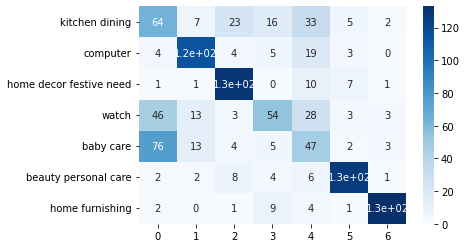

In [103]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Méthode combinée <a class="anchor" id="chapter21"></a>

On va combiner les prédictions des données textuelles avec le meilleur ARI et celui de l'image. On va donc prendre la méthode "bag of word" et la deuxième méthode. On récupère la matrice de confusion de "bag of word", et on fait la moyenne.

In [157]:
tab = pd.read_csv("use")
tab.index = tab["Categories"]
tab.drop(["Categories"], axis = 1, inplace = True)
tab

,0,1,2,3,4,5,6
Categories,,,,,,,
baby care,8,3,0,28,1,92,18
beauty personal care,136,2,2,1,3,5,1
computer,11,5,0,0,133,0,1
home decor festive need,0,103,3,12,10,1,21
home furnishing,0,3,0,145,0,0,2
kitchen dining,5,46,0,0,8,0,91
watch,0,0,150,0,0,0,0


In [158]:
tab_max = tab.max(axis = 1)
tab_max = tab_max / 150
tab_max = tab_max.map(lambda n: '{:.2%}'.format(n))
tab_max = pd.DataFrame(tab_max)
tab_max = tab_max.rename(columns = {0: 'Pourcentage_texte'})
tab_max

,Pourcentage_texte
Categories,
baby care,61.33%
beauty personal care,90.67%
computer,88.67%
home decor festive need,68.67%
home furnishing,96.67%
kitchen dining,60.67%
watch,100.00%


In [159]:
df_cm_max = df_cm.max(axis = 1)
df_cm_max = df_cm_max / 150
df_cm_max = df_cm_max.map(lambda n: '{:.2%}'.format(n))
df_cm_max = pd.DataFrame(df_cm_max)
df_cm_max.reset_index(inplace = True)
df_cm_max = df_cm_max.rename(columns = {0 : 'Pourcentage_image', 'index' : 'Categories'})
df_cm_max.index = df_cm_max["Categories"]
df_cm_max.drop(["Categories"], axis = 1, inplace = True)
df_cm_max = df_cm_max.sort_values(by=['Categories'])
df_cm_max

,Pourcentage_image
Categories,
baby care,50.67%
beauty personal care,84.67%
computer,76.67%
home decor festive need,86.67%
home furnishing,88.67%
kitchen dining,42.67%
watch,36.00%


Maintenant que nous avons le pourcentage de chacune des prédictions, on va créer un tableau et on prioriser les techniques de représentations des produits.

In [160]:
tab_combiner = pd.concat([tab_max, df_cm_max], axis=1, join='inner')
tab_combiner

,Pourcentage_texte,Pourcentage_image
Categories,,
baby care,61.33%,50.67%
beauty personal care,90.67%,84.67%
computer,88.67%,76.67%
home decor festive need,68.67%,86.67%
home furnishing,96.67%,88.67%
kitchen dining,60.67%,42.67%
watch,100.00%,36.00%
